In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from imageio import imread
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    读取图片，应用beam search生成文本描述。
    :param encoder: 编码模型
    :param decoder: 解码模型
    :param image_path: 图片地址
    :param word_map: 词典
    :param beam_size: 在每个解码步骤中要考虑的序列数，top k
    :return: 文本描述, 权重的可视化效果
    """

    k = beam_size
    vocab_size = len(word_map)

    """
    读取图片 + 预处理： 三通道，标准化，转换成PyTorch能够接收的输入size
    """
    
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = np.array(Image.fromarray(img).resize((256, 256)))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)
        
    """）
    解码实践
    """
    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    # 编码
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    # 获取图片size
    enc_image_size = encoder_out.size(1)
    # 获取编码图片维度（channel数）
    encoder_dim = encoder_out.size(3)

    # 维度转换：(1, num_pixels, encoder_dim)
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    # 像素数量
    num_pixels = encoder_out.size(1)

                                                                 
    # 将batch size视为k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # 在每个step保存top k个上一个词，那么在第一个step ，共有k个<start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # 初始化保存top k个序列的变量
    seqs = k_prev_words  # (k, 1)

    # 以0分初始化保存top k个序列的分数
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    # 保存top k个序列的权重
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # 保存完整文本序列的列表，以及序列的权重和分数
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    
    """
    解码
    """
    step = 1
    # 初始化h，c
    h, c = decoder.init_hidden_state(encoder_out)

    # s <= k, 因为随着解码的进行，不断的有<end>被预测出来

    while True:
        # embeding (s, embed_dim)
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)
        # 编码 (s, encoder_dim), (s, num_pixels)
        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)
        # size转换-->(s, enc_image_size, enc_image_size)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)
        # gating scalar, (s, encoder_dim)
        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        # 更新h， c
        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)
        # scores预测，转换为概率
        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # 分数累加
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        # 对于第一个step，所有的分数都一样
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            # Unroll and find top scores, and their unrolled indices
            # 获得最高分的索引 --> (s)
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        # 转换成所有词索引 --> (s)
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # 向序列添加新词，权重 --> (s, step+1)
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        # (s, step+1, enc_image_size, enc_image_size)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)

        # 对终止编码的判断
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))


        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # 处理未结束的序列
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # 如果step过大，同样终止解码，避免死循环
        if step > 50:
            break
        step += 1

    """
    获取分值最高的文本序列以及相应的权重并返回
    """                            
    # 获取分值最高的序列索引
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas
    # ——————————————————————————————————————————————————————————

In [3]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    可视化的文本与权重
    :param image_path: 图片路径
    :param seq: 文本序列
    :param alphas: 权重
    :param rev_word_map: ix2word，词典的反响映射
    :param smooth: 是否对权重做平滑处理
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

/Users/Lxy/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'models.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/Lxy/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/Lxy/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's 

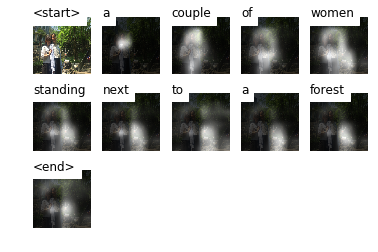

In [4]:
"""
预测及可视化
"""   

# 加载模型
checkpoint = torch.load('../pretrained/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar', 
                        map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# 加载词典 (word2ix)
with open('../pretrained/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json', 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# 引入注意力机制的编码与解码， beam search
seq, alphas = caption_image_beam_search(encoder, decoder, '/Users/Lxy/Pictures/IMG_5984.jpeg', word_map, 5)
alphas = torch.FloatTensor(alphas)

# 可视化文本，权重高的区域会被高亮显示
visualize_att('/Users/Lxy/Pictures/IMG_5984.jpeg', seq, alphas, rev_word_map)